# **Product Vision Search:** Build a Product recognition engine in one hour
This example is using a Kaggle dataset for product recognition. The goal is to extract a csv for bulk import in Product Vision Search  
**Useful links:**  
https://github.com/zinjiggle/google-product-search-simple-ui  
https://github.com/GoogleCloudPlatform/python-docs-samples/tree/master/vision/cloud-client/product_search

## 0. Install Google Cloud Vision library

In [ ]:
#pip install google-cloud-vision

Init with your own project

In [1]:
project_id='pod-fr-retail'
location='europe-west1'
product_set='kaggle_shoes'
bucket_name="pod-fr-retail-kaggle"
gcs_bucket="gs://"+bucket_name+"/"

In [2]:
from google.cloud import vision_v1

## 1. Check index time of product sets 

In [3]:
import time
from google.cloud import vision_v1
client = vision_v1.ProductSearchClient()
parent = client.location_path(project_id, location)
name = client.product_set_path(project_id, location, product_set)
for element in client.list_product_sets(parent):
    #print(element)
    print('Index name:', element.name)
    print('Last index:',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(element.index_time.seconds)))
    print('------')
    pass


Index name: projects/pod-fr-retail/locations/europe-west1/productSets/kaggle_shoes
Last index: 2022-10-18 05:51:51
------
Index name: projects/pod-fr-retail/locations/europe-west1/productSets/pvs_shoes
Last index: 2022-10-18 05:51:51
------


## 2. Search a product in your catalog

In [47]:
from google.cloud import vision
from google.cloud import storage
from IPython.display import Image, display
import pandas as pd

def get_image(uri):
    client_storage = storage.Client() # Implicit environment set up
    bucket = uri.split("/")[2]
    object_name = "/".join(uri.split("/")[3:])
    # with explicit set up:
    # client = storage.Client.from_service_account_json('key-file-location')
    bucket = client_storage.get_bucket(bucket)
    blob = bucket.get_blob(object_name)
    return(Image(blob.download_as_bytes()))
    
def get_similar_products_file(
        project_id,
        location,
        product_set_id,
        product_category,
        file_path,
        filter,
        max_results
):
    """Search similar products to image.
    Args:
        project_id: Id of the project.
        location: A compute region name.
        product_set_id: Id of the product set.
        product_category: Category of the product.
        file_path: Local file path of the image to be searched.
        filter: Condition to be applied on the labels.
                Example for filter: (color = red OR color = blue) AND style = kids
                It will search on all products with the following labels:
                color:red AND style:kids
                color:blue AND style:kids
        max_results: The maximum number of results (matches) to return. If omitted, all results are returned.
    """
    # product_search_client is needed only for its helper methods.
    
    image_annotator_client = vision.ImageAnnotatorClient()

    # Read the image as a stream of bytes.
    with open(file_path, 'rb') as image_file:
        content = image_file.read()

    # Create annotate image request along with product search feature.
    image = vision.types.image_annotator_pb2.Image(content=content)
    product_search_client = vision.ProductSearchClient()
    # product search specific parameters
    product_set_path = product_search_client.product_set_path(
        project=project_id, location=location,
        product_set=product_set_id)
    product_search_params = vision.types.ProductSearchParams(
        product_set=product_set_path,
        product_categories=[product_category],
        filter=filter)
    image_context = vision.types.ImageContext(
        product_search_params=product_search_params)

    # Search products similar to the image.
    response = image_annotator_client.product_search(
        image,
        image_context=image_context,
        max_results=max_results
    )
    
    index_time = response.product_search_results.index_time
    print('Last Product index:',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(index_time.seconds)))

    results = response.product_search_results.results
    return results

def display_results(results):
    print('Search results for : \n')
    display(Image(file_path))
    i=0
    print('\n')
    for result in results:
        print('-----Result ', i, ' ------')
        product_search_client = vision.ProductSearchClient()
        image = product_search_client.get_reference_image(name=result.image)
        display(get_image(image.uri))
        product = result.product
        print('Score(Confidence): {}'.format(result.score))
        print('Image name: {}'.format(result.image))
        print('Product name: {}'.format(product.name))
        print('Product display name: {}'.format(
            product.display_name))
        print('Product description: {}\n'.format(product.description))
        print('Product labels: \n')
        df=[]
        for p in product.product_labels:
            df.append([p.key, p.value])
        print(pd.DataFrame(df, columns=["Key", "Value"]))
        i=i+1
        print('\n')

def analyse_results(results):
    df=[]
    print('Search results for : \n')
    display(Image(file_path))
    i=0
    print('\n')
    for result in results:
        if result.score>0.1:
            for p in result.product.product_labels:
                df.append([p.key, p.value])
    data=pd.DataFrame(df, columns=["Key", "Value"])
    cnt_per_key =  data.groupby(["Key", "Value"])["Value"].count().reset_index(name="count")
    cnt_per_key['ranking'] = cnt_per_key.groupby(["Key"])['count'].rank(method='first', ascending=False)
    #print(cnt_per_key)
    print(cnt_per_key[cnt_per_key.ranking==1])
 

In [50]:
product_category="apparel-v2"
file_path="sebago.jpeg"


Last Product index: 2022-10-18 17:19:33
Search results for : 



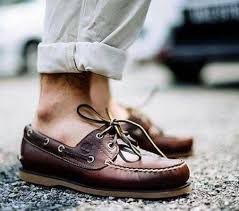



   Key                   Value  count  ranking
0  cl1  chaussures-accessoires    298      1.0
5  cl2       chaussuresdeville    274      1.0
8  cl3                 bateaux    159      1.0


In [51]:
results=get_similar_products_file(
        project_id,
        location,
        product_set,
        product_category,
        file_path,
        filter="",
        max_results=300
)
analyse_results(results)

Last Product index: 2022-10-18 17:19:33
Search results for : 



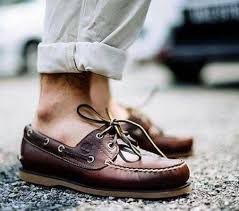



-----Result  0  ------


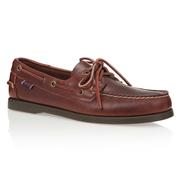

Score(Confidence): 0.5198826193809509
Image name: projects/pod-fr-retail/locations/europe-west1/products/17475746/referenceImages/1000010365-17475746-0
Product name: projects/pod-fr-retail/locations/europe-west1/products/17475746
Product display name: 17475746
Product description: 

Product labels: 

   Key                   Value
0  cl1  chaussures-accessoires
1  cl2       chaussuresdeville
2  cl3                 bateaux


-----Result  1  ------


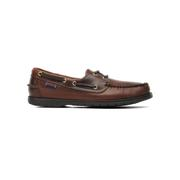

Score(Confidence): 0.5014159083366394
Image name: projects/pod-fr-retail/locations/europe-west1/products/22622211/referenceImages/1000010365-22622211-1
Product name: projects/pod-fr-retail/locations/europe-west1/products/22622211
Product display name: 22622211
Product description: 

Product labels: 

   Key                   Value
0  cl1  chaussures-accessoires
1  cl2       chaussuresdeville
2  cl3                 bateaux


-----Result  2  ------


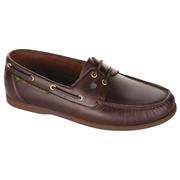

Score(Confidence): 0.48913875222206116
Image name: projects/pod-fr-retail/locations/europe-west1/products/8360820/referenceImages/1000010365-8360820-3
Product name: projects/pod-fr-retail/locations/europe-west1/products/8360820
Product display name: 8360820
Product description: 

Product labels: 

   Key                   Value
0  cl1  chaussures-accessoires
1  cl2       chaussuresdeville
2  cl3                 bateaux


-----Result  3  ------


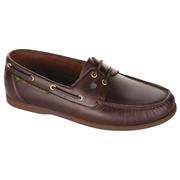

Score(Confidence): 0.48913875222206116
Image name: projects/pod-fr-retail/locations/europe-west1/products/11867219/referenceImages/1000010365-11867219-3
Product name: projects/pod-fr-retail/locations/europe-west1/products/11867219
Product display name: 11867219
Product description: 

Product labels: 

   Key                   Value
0  cl1  chaussures-accessoires
1  cl2       chaussuresdeville
2  cl3                 bateaux


-----Result  4  ------


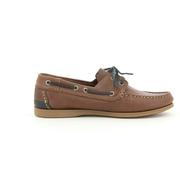

Score(Confidence): 0.48422303795814514
Image name: projects/pod-fr-retail/locations/europe-west1/products/18840186/referenceImages/1000010383-18840186-3
Product name: projects/pod-fr-retail/locations/europe-west1/products/18840186
Product display name: 18840186
Product description: 

Product labels: 

   Key                   Value
0  cl1  chaussures-accessoires
1  cl2       chaussuresdeville
2  cl3                mocassin


-----Result  5  ------


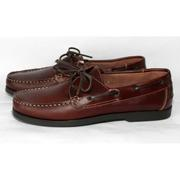

Score(Confidence): 0.47964051365852356
Image name: projects/pod-fr-retail/locations/europe-west1/products/15260528/referenceImages/1000010365-15260528-0
Product name: projects/pod-fr-retail/locations/europe-west1/products/15260528
Product display name: 15260528
Product description: 

Product labels: 

   Key                   Value
0  cl1  chaussures-accessoires
1  cl2       chaussuresdeville
2  cl3                 bateaux


-----Result  6  ------


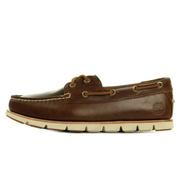

Score(Confidence): 0.4699595868587494
Image name: projects/pod-fr-retail/locations/europe-west1/products/7532744/referenceImages/1000010365-7532744-1
Product name: projects/pod-fr-retail/locations/europe-west1/products/7532744
Product display name: 7532744
Product description: 

Product labels: 

   Key                   Value
0  cl1  chaussures-accessoires
1  cl2       chaussuresdeville
2  cl3                 bateaux


-----Result  7  ------


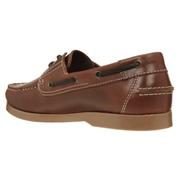

Score(Confidence): 0.4673921763896942
Image name: projects/pod-fr-retail/locations/europe-west1/products/17144081/referenceImages/1000010365-17144081-2
Product name: projects/pod-fr-retail/locations/europe-west1/products/17144081
Product display name: 17144081
Product description: 

Product labels: 

   Key                   Value
0  cl1  chaussures-accessoires
1  cl2       chaussuresdeville
2  cl3                 bateaux


-----Result  8  ------


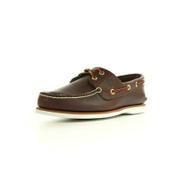

Score(Confidence): 0.46594005823135376
Image name: projects/pod-fr-retail/locations/europe-west1/products/1128455/referenceImages/1000010365-1128455-0
Product name: projects/pod-fr-retail/locations/europe-west1/products/1128455
Product display name: 1128455
Product description: 

Product labels: 

   Key                   Value
0  cl1  chaussures-accessoires
1  cl2       chaussuresdeville
2  cl3                 bateaux


-----Result  9  ------


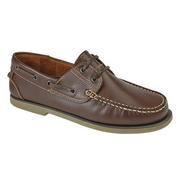

Score(Confidence): 0.46515655517578125
Image name: projects/pod-fr-retail/locations/europe-west1/products/63451/referenceImages/1000010365-63451-0
Product name: projects/pod-fr-retail/locations/europe-west1/products/63451
Product display name: 63451
Product description: 

Product labels: 

   Key                   Value
0  cl1  chaussures-accessoires
1  cl2       chaussuresdeville
2  cl3                 bateaux




In [52]:
results=get_similar_products_file(
        project_id,
        location,
        product_set,
        product_category,
        file_path,
        filter="",
        max_results=10
)
display_results(results)

In [17]:
results=get_similar_products_file(
        project_id,
        location,
        product_set,
        product_category,
        file_path,
        filter="",
        max_results=300
)
df=[]
print('Search results for :',file_path,' \n')
for result in results:
    for p in result.product.product_labels:
        df.append([p.key, p.value])
data=pd.DataFrame(df, columns=["Key", "Value"])
cnt_per_key =  data.groupby(["Key", "Value"])["Value"].count().reset_index(name="count")
cnt_per_key['ranking'] = cnt_per_key.groupby(["Key"])['count'].rank(method='first', ascending=False)
print(cnt_per_key)
print(cnt_per_key[cnt_per_key.ranking==1])

Last Product index: 2022-10-18 05:51:51
Search results for : balerine.jpg  

    Key                   Value  count  ranking
0   cl1  chaussures-accessoires    299      1.0
1   cl2       basket-sportswear      3      4.0
2   cl2         bottes-bottines     22      2.0
3   cl2       chaussuresdetente      7      3.0
4   cl2       chaussuresdeville    267      1.0
5   cl3               ballerine    212      1.0
6   cl3                  basket      3      8.0
7   cl3                 bateaux      1     12.0
8   cl3                   botte     20      3.0
9   cl3           bottine-boots      2      9.0
10  cl3      chausson-pantoufle      5      6.0
11  cl3                   derby      4      7.0
12  cl3                escarpin     21      2.0
13  cl3              espadrille      2     10.0
14  cl3                mocassin     16      4.0
15  cl3                   sabot      2     11.0
16  cl3        sandale-nu-pieds     11      5.0
   Key                   Value  count  ranking
0  cl1  chau